#MOOC ACADEMY: Modeling Prediction

_MOOCs are the holy grail of free, quality, and universal education. However they are plagued with low retention rates of users which makes them less effective._

_We wondered if we could boost the retention rate by predicting whether a user would dropout based on their initial interaction with the course. If we can predict a user’s likelihood of dropping out in advance, we can take timely corrective action to prevent this._

<img src="./images/mooc-3.jpg" width=600 height=600/>

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
#date time
import datetime
import dateutil

# Cross-Validation
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

#LINEAR SVC
from sklearn import svm
from sklearn.grid_search import GridSearchCV
from sklearn.svm import LinearSVC

#Logistic Regression and KFOLD
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold

#ROC
from sklearn.metrics import roc_curve, auc

#LASSO PLOT
from sklearn.linear_model import lasso_path, enet_path

# Reading in the master data file

In [3]:
# Read in master data file from '1_data_management.ipynb': 'usertasks.txt
df_usertask=pd.read_csv("./data/usertasks.txt", sep='\t',parse_dates=['date'], date_parser=dateutil.parser.parse)

# drop the first column
df_usertask=df_usertask.drop(df_usertask.columns[0], axis=1)

#fill NAN's with 0's
df_usertask = df_usertask.fillna(0)
#df_usertask.head()

In [4]:
#Ensure that the data type is correct
df_usertask.dtypes

user_id                          object
username                         object
dropout                           int64
course_day                        int64
course_week                       int64
date                     datetime64[ns]
total_time_30                   float64
total_video_time_30             float64
total_problem_time_30           float64
total_forum_time_30             float64
total_text_time_30              float64
nvideo                          float64
nforum_activity                 float64
nproblem_attempts               float64
nproblems                       float64
nproblems_correct               float64
dtype: object

In [5]:
# Data Information
print 'Max number of course days:', np.sort(df_usertask['course_day'].unique()).max()
print 'Size of the dataframe: df_usertask', df_usertask.shape
print 'Total number of unique userIDs', len(df_usertask.user_id.unique())

Max number of course days: 123
Size of the dataframe: df_usertask (46681, 16)
Total number of unique userIDs 4956


#Prediction Modeling - General Steps:

Listed below are the general steps laid out for prediction modeling

1. __Set up the dataframes used for modeling__:
Each row of the dataframe has a unique userID and its dropout classification.
    * Dataframe a : _df_pred_a_
        * **Feature Columns : Video, Forum, Problem Activity** (i.e the total activity for each category for each user in the first 3 weeks)
    * Dataframe b : _df_pred_b_
        * **Feature Columns: Every Day for the first 3 weeks** (i.e. the sum total across all activities for each day for each user)
    * Note: Should use only first 21 days as predictor columns
    
2. __Train-Validate-Test__
    * Balance Dataset:
        * (i) 50% dropout and 50% completed as part of training data set
        * (ii) Remove 'inactive users' from the training data set 
    * Standardize
    * 5-fold Cross Validation
    * Parameter Tuning

3. __Customized Scoring Function__

4. __Model Prediction and ROC Curves for DataFrame A__
    * (a) Building Prediction Models
    * (b) ROC Curves

5. __Model Prediction and ROC Curves for DataFrame B__
    * (a) Building Prediction Models
    * (b) ROC Curves

6. __Feature Selection and Regularization__

####Models Explored: 
1. SVM (Linear)
2. Logit Regression with Lasso

# Definitions:

1. __Completers__: User completion is defined by this project to mean:
    * Those users who enrolled in the class within 2 weeks of the course start AND
    * Those users who were active (i.e. engaging with the different course modules) within the last month of the course AND
    * Those users who had at least one hour of activity within the last month
The main reason for this definition is we account for the varying nature of MOOC's where users come from diverse areas and educational backgrounds, and their goal is to learn some part or all the material but unlike a university setting, not always complete with a passing grade. In this course the passing grade was 60% which we deemed was too high. Our course completion definition gives more importance to sustained user activity throughout the course versus getting a high grade. More discussion on the course completion definition and our reasoning behind it is further described in '2_eda.ipynb'

2. __Dropouts__: Are those who were not deemed to be completers. 

3. __Inactive Users__: Are those who spent 90% or more of their time on activities (videos, problems, forums, etc.) in the first one week of the course.

4. __Active Users__: Are those who are not inactive users.

5. __Dataframe A__: Shows the total interaction (videos, problems, forum visits, etc.) of the user within the first three weeks. Each feature column represents the sum total of ONE activity performed by the user within the first three weeks. This dataframe also shows the observed dropout result of the user where 1 = dropout, and 0 = completer.

6. __Dataframe B__: Shows the total interaction (videos, problems, forum visits, etc.) of the user within the first three weeks. Here each feature column represents one day and the TOTAL activity performed by the user in that day. There are 21 such columns, each representing the TOTAL user activity per day per user.

#<span style="color:blue">Step 1: Set up the two dataframes (A and B)</span>

###a) Dataframe A : df_pred_a

Feature Columns : Video, Forum, Problem Activity (i.e the total activity for each category for each user in the first 3 weeks)

In [6]:
# Note: Should use only first 21 days as predictor 
train_days = 21
df_usertask_pred = df_usertask[df_usertask.course_day <= train_days]
df_usertask_pred = df_usertask_pred.fillna(0)
print df_usertask_pred.shape

(15219, 16)


In [7]:
#(a) Dataframe a: 
# Feature Columns : Video, Forum, Problem Activity (total of each activity in first 3 weeks)
df_pred_a = df_usertask_pred.groupby(['user_id', 'username', 'dropout']).sum()
df_pred_a.drop(['course_day', 'course_week'], axis=1, inplace= True)
df_pred_a=df_pred_a.reset_index()
print 'Size of the df_pred_a dataframe: ', df_pred_a.shape
#df_pred_a.head()

Size of the df_pred_a dataframe:  (4331, 13)


###b) Dataframe B : df_pred_b

Feature Columns: Each Day for the first 3 weeks (i.e. the sum total across all activities for each day for each user).

We need to aggregate user activity for each day for each user. There can be several ways to do this, but the way we came up with an aggregation function is: 

$$
Daily Aggregated Activity_{j} = \sum_{i} \frac{Weight_{i} * Activity_{i,j}}{Max Activity_{i}}
$$
where: 

* $Weight_{i}$ = weight depending on our initial understanding of the importance of each activity towards user engagement
* $Activity_{i,j}$ = ith activity performed by the j-th user
* $Max Activity_{i}$ = maximum of the activity i-th across all j users

In [8]:
#(b) Dataframe b : df_pred_b
# Feature Columns: Each Day for the first 3 weeks (i.e. the sum total across all activities for each day for each user)

df_pred_b = df_usertask_pred.groupby(['user_id', 'username', 'dropout', 'course_day']).sum()
df_pred_b.drop(['course_week'], axis=1, inplace= True)
print df_pred_b.shape
#df_pred_b.head()

(15219, 10)


In [9]:
#Scaling Factors 
#-----------------------

#Max Activity
max_totalVideo = df_pred_b['total_video_time_30'].max(axis=0)
max_totalProblem = df_pred_b['total_problem_time_30'].max(axis=0)
max_totalForum = df_pred_b['total_forum_time_30'].max(axis=0)
max_totalText = df_pred_b['total_text_time_30'].max(axis=0)
max_nVid = df_pred_b['nvideo'].max(axis=0)
max_nForum = df_pred_b['nforum_activity'].max(axis=0)
max_nProbAttempt = df_pred_b['nproblem_attempts'].max(axis=0)
max_nProb = df_pred_b['nproblems'].max(axis=0)
max_nProbCorrect = df_pred_b['nproblems_correct'].max(axis=0)

#Weights (based on the importance of the feature)
wt_forum = 1
wt_prob = 5
wt_video = 10

In [10]:
#Generic Activity Indicator Column

df_pred_b['activity'] = (df_pred_b['total_video_time_30']/max_totalVideo + 
                         df_pred_b['total_problem_time_30']/max_totalProblem + 
                         df_pred_b['total_forum_time_30']/max_totalForum + 
                         df_pred_b['total_text_time_30']/max_totalText + 
                         df_pred_b['nvideo']/max_nVid * wt_video + 
                         df_pred_b['nforum_activity']/max_nForum * wt_forum + 
                         df_pred_b['nproblem_attempts']/max_nProbAttempt * wt_prob +
                         df_pred_b['nproblems']/max_nProb * wt_prob + 
                         df_pred_b['nproblems_correct']/max_nProbCorrect * wt_prob)

df_pred_b = df_pred_b.reset_index()
df_pred_b = df_pred_b[['user_id', 'username', 'dropout', 'course_day', 'activity']]
#df_pred_b.head()

In [11]:
df_pred_b = df_pred_b.pivot(index='user_id', columns='course_day', values='activity')
#df_pred_b.head()

In [12]:
# Fill in 0's for each column which has NaN's
df_pred_b = df_pred_b.fillna(0)

# Create a dataframe with unique user_id's and corresponding dropout categorization
df_unique = df_pred_a.copy()
df_unique = df_unique[['user_id', 'dropout']]
df_unique = df_unique.set_index('user_id')

# Add a column in 'df_pred_b' dataframe with a column for dropouts based on 'df_unique
df_pred_b['dropout'] = df_unique.dropout
print 'Size of the df_pred_b dataframe: ', df_pred_b.shape
#df_pred_b.head()

Size of the df_pred_b dataframe:  (4331, 22)


#<span style="color:blue">Step 2: Create Train-Test Sets</span>

### Create train-test datasets for an imbalanced dataset for Dataframe A and Dataframe B

For an **imbalanced** dataset we create a training set which has a random sample of 70% of the dataframe.

In [13]:
# DATAFRAME A: df_pred_a: For unbalanced data:
itrain, itest = train_test_split(xrange(df_pred_a.shape[0]), train_size=0.7)

mask_a=np.ones(df_pred_a.shape[0], dtype='int')
mask_a[itrain]=1
mask_a[itest]=0
mask_a = (mask_a==1)
trainSet_a = df_pred_a[mask_a]
testSet_a = df_pred_a[~mask_a]

lcols_a=list(df_pred_a.columns)
lcols_a.remove('user_id')
lcols_a.remove('username')
lcols_a.remove('dropout')

STANDARDIZABLE_a = lcols_a

In [14]:
# DATAFRAME B: df_pred_b: For unbalanced data:
itrain, itest = train_test_split(xrange(df_pred_b.shape[0]), train_size=0.7)

mask_b=np.ones(df_pred_b.shape[0], dtype='int')
mask_b[itrain]=1
mask_b[itest]=0
mask_b = (mask_b==1)
trainSet_b = df_pred_b[mask_b]
testSet_b = df_pred_b[~mask_b]

lcols_b=list(df_pred_b.columns)
lcols_b.remove('dropout')

STANDARDIZABLE_b = lcols_b

### Create train-test datasets by balancing an imbalanced dataset

Our edX dataset is highly imbalanced with approximately **~90%** of the users who **dropout** whereas about **~10%** who actually **complete** the course. Hence to make a balanced training dataset we use 70% of the users who are 'completers' and match it with the same number of randomly chosen dropouts. Our goal in balancing the training dataset is to better train the model on the characteristics of the two user groups (aka dropouts and completers).  

In [15]:
# Function to balance the dataset choosing 70% of the completors and the same number of dropouts
# Returns: train dataframe, test dataframe, and a mask for dropouts and for completers

def balance_set(df):
    
    df1 = df[df.dropout==1]
    df0 = df[df.dropout==0]
    noOfCompleters = df1.shape[0]
    noOfDropouts = df0.shape[0]
    pctChoosen = 0.7
    
    # Generates train and test sets for the dropouts
    itrain0, itest0 = train_test_split(xrange(noOfDropouts), train_size=pctChoosen)
    mask0=np.ones(noOfDropouts, dtype='int')
    mask0[itrain0]=1
    mask0[itest0]=0
    mask0 = (mask0==1)
    trainSet0 = df0[mask0]
    testSet0 = df0[~mask0]
    
    # Generates the same size of train and test sets for the completers    
    itrain1, itest1 = train_test_split(xrange(noOfCompleters), train_size=int(np.around(pctChoosen * noOfDropouts)))
    mask1=np.ones(noOfCompleters, dtype='int')
    mask1[itrain1]=1
    mask1[itest1]=0
    mask1 = (mask1==1)
    trainSet1 = df1[mask1]
    testSet1 = df1[~mask1]
    
    # Merges the train and test sets between the dropouts and completers
    df_train = pd.concat([trainSet0,trainSet1])
    df_test = pd.concat([testSet0,testSet1])
    
    return df_train, df_test, mask0, mask1

In [16]:
# Balance the Imbalanced Datasets
df_train_bal_a, df_test_bal_a, mask0_a, mask1_a = balance_set(df_pred_a)
df_train_bal_b, df_test_bal_b, mask0_b, mask1_b = balance_set(df_pred_b)

## Standardization

Standardization of the features is important because each feature taken as it is with different scales would not contribute equally to the analysis. In our case the features with time length (in seconds) are much larger in magnitude than the ones such as 'number of problems attempted' or 'number of videos watched', hence the former features would outweight the latter ones without standardization. Standardizing involves scaling the data columns so that it has 0 mean and is described in units of its standard deviation.  

In [17]:
# Standardize the train and test set
def to_Standardize(df, col_list, mask):
    for col in col_list:
        valstrain=df[col].values[mask]
        valstest=df[col].values[~mask]
        scaler=StandardScaler().fit(valstrain)
        outtrain=scaler.transform(valstrain)
        outtest=scaler.fit_transform(valstest)
        out=np.empty(mask.shape[0])
        out[mask]=outtrain
        out[~mask]=outtest
        df[col]=out
    return df

####Standardize the Unbalanced Dataset

In [18]:
# Standardize the Imbalanced Datasets
df_pred_std_a = to_Standardize(df_pred_a, STANDARDIZABLE_a, mask_a)
df_pred_std_b = to_Standardize(df_pred_b, STANDARDIZABLE_b, mask_b)

####Standardize the Balanced Dataset

In [19]:
#-----------A---------------------
df_pred_bal_a = pd.concat([df_train_bal_a, df_test_bal_a])
mask_bal_a = np.append(mask0_a,mask1_a)

#-----------B---------------------
df_pred_bal_b = pd.concat([df_train_bal_b, df_test_bal_b])
mask_bal_b = np.append(mask0_b,mask1_b)

# Standardizing AFTER BALANCING the Datasets
df_pred_std_bal_a = to_Standardize(df_pred_bal_a, STANDARDIZABLE_a, mask_bal_a)
df_pred_std_bal_b = to_Standardize(df_pred_bal_b, STANDARDIZABLE_b, mask_bal_b)

###5-FOLD CROSS VALIDATION and PARAMETER TUNING

We carry out 5-fold cross validation of the training data.
* Create n_folds partitions of the training data.
* We then train on n_folds -1 of these partitions, and test on the remaining partition. There are n_folds such combinations of partitions (or folds), and thus we obtain n_fold risks.
* Finally we average the error or risk of all such combinations

Using GridSearchCV over the parameter grid of regularization coefficients in the Cs array, our aim is to get the best fit classifier using 5-fold cross validation.

In [20]:
# Cross-Validation

def cv_optimize(clf,parameters,X,y,n_folds=5,score_func=None):
    cvd = GridSearchCV(clf,parameters,cv=n_folds,scoring=score_func)
    cvd.fit(X, y)
    return cvd.best_estimator_

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

# <span style="color:blue">Step 3: Customized Scoring Function</span>

The generic accuracy function as part of GridSearch is not a good measure of accuracy since we have a highly unbalanced dataset.  
The generic accuracy score function weighs the accuracy of the different scenarios (e.g. True Negative or False Positive) equally. With a customized scoring function we want to put more weight on predicting that a user will complete when they actually drop out versus predicting someone is going to drop out when in reality they complete the course. 

* __TNC = True Negative Cost__, is the cost associated with correctly predicting someone who completes the course, which in our case is 0. 
* __TPC = True Positive Cost__, is the cost associated with correctly predicting a dropout, which is again 0 in our case. 
* __FNC = False Negative Cost__, is the cost associated with predicting someone is going to complete but in reality that user drops out. In our case we have attributed this to have the highest cost representing the additional material and teaching resources dedicated to these users. 
* __FPC = False Positive Cost__, is the cost of predicting someone is going to drop out but in reality that user completes the course. We have denoted it with a small cost of 1.0. 

In [21]:
#Score Function

#Costs
tnc=0.0
tpc=0.0
fnc=10.0
fpc=5.0

risk_matrix=np.array([[tnc, fpc],[fnc, tpc]])
risk_matrix
u = - risk_matrix

def dropout_gain(clf, X, y):
    ypred = clf.predict(X)
    c=confusion_matrix(y,ypred)
    score=np.sum(c*u)/np.sum(c)
    return score

#<span style="color:blue">Step 4: Model Prediction and ROC Curves for Dataframe A</span>

##Step 4a: Model Prediction on Dataframe A

In this section we will use the tools and techniques we lay out earlier in this notebook to do model prediction. We start off with using **Dataframe A** which has the total activity per user in the first 3 weeks as feature columns.

### Model Set 1: Linear SVM
Support Vector Machines (SVM) are very powerful discriminant classifiers. Since the purpose of our prediction modeling is to classify users as dropouts or completors, SVM was our initial choice. Linear SVM was choosen over the kernelized SVM since it performs much faster on large datasets. The default linear SVM works by minimizing a decision risk called the hinge-loss.

### (a) Standardized, Unbalanced Dataset, with both Active and Inactive Users

In [22]:
# Best Classifier for LINEAR SVM (Unbalanced, Standardized, Active+Inactive users)
clfsvm_a1, Xtrain, ytrain, Xtest_svm_a1, ytest_svm_a1 = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df_pred_std_a, lcols_a, 'dropout', 1, mask=mask_a)

using mask
############# based on standard predict ################
Accuracy on training data: 0.91
Accuracy on test data:     0.92
[[  22   84]
 [  15 1179]]
########################################################


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:12: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [23]:
print 'Best clfsvm choosen has the following characteristics: '
print 'Classifier parameters: ', clfsvm_a1
print ''
print 'Classifier coefficients: ',clfsvm_a1.coef_

Best clfsvm choosen has the following characteristics: 
Classifier parameters:  LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)

Classifier coefficients:  [[-0.04392249  0.01519727 -0.07323978 -0.03882586  0.00745644  0.03001809
  -0.05514273 -0.0121078  -0.05237674 -0.13499887]]


####Model Results:
The GridSearchCV finds C=0.001 to be the best regularization regularization coefficient among all the Cs. We get a model accuracy of ~0.90 on the test data.

From this result, the false positives are 129 users and the false negatives are 2 users. They represent instances where our model incorrectly predicts user behavior. These are the two aspects of our results that we want to focus on improving in subsequent modeling. 

### (b) Standardized, Balanced Dataset, with both Active and Inactive Users

In [24]:
# Find Best Classifier for LINEAR SVM (Balanced, Standardized)
clfsvm_a2, Xtrain, ytrain, Xtest_svm_a2, ytest_svm_a2 = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df_pred_std_bal_a, lcols_a, 'dropout', 1, mask=mask_bal_a)

using mask
############# based on standard predict ################
Accuracy on training data: 0.82
Accuracy on test data:     0.84
[[ 147   45]
 [ 576 3022]]
########################################################


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:12: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [25]:
print 'Best clfsvm choosen has the following characteristics: '
print 'Classifier parameters: ', clfsvm_a2
print ''
print 'Classifier coefficients: ',clfsvm_a2.coef_

Best clfsvm choosen has the following characteristics: 
Classifier parameters:  LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)

Classifier coefficients:  [[-0.020716   -0.07189765 -0.14978169 -0.11856359 -0.00211567  0.19649719
  -0.10499043  0.17655946 -0.6752676  -0.63512562]]


####Model Results:

The GridSearchCV finds C=0.001 to be the best regularization regularization coefficient among all the Cs. We get a model accuracy of ~0.87 on the test data.

From this result, the false positives are 48 users and the false negatives are 441 users. They represent instances where our model incorrectly predicts user behavior. Again, these are the two aspects of our results that we want to focus on improving in subsequent modeling.

As compared to the previous modeling, when we balance the dataset we see lower accuracy. The reason for this is that when we try to balance a highly unbalanced dataset, we end up with a very small training set (~13% of the total data). Hence, while balancing dataset should ideally help the model to better learn and predict on the test set, the small sample size of our training set defeats the purpose. Even then the accuracy is still fairly high (~0.87).

Balancing our dataset did not help improve our accuracy. This motivates us to try a different scoring function to see if we can

###(c) Standardized, Unbalanced Dataset, with both Active and Inactive Users, AND with Customized Score Function

In [26]:
# Best Classifier for LINEAR SVM (Unbalanced, Standardized, Active+Inactive users, Custom Score Function)
clfsvm_a3, Xtrain, ytrain, Xtest_svm_a3, ytest_svm_a3 = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df_pred_std_a, lcols_a, 'dropout', 1, mask=mask_a, score_func=dropout_gain)

using mask
############# based on standard predict ################
Accuracy on training data: 0.91
Accuracy on test data:     0.92
[[   2  104]
 [   3 1191]]
########################################################


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:12: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


###(d) Standardized, Balanced Dataset, with both Active and Inactive Users, AND with Customized Score Function

In [27]:
# Find Best Classifier for LINEAR SVM (Balanced, Standardized)
clfsvm_a4, Xtrain, ytrain, Xtest_svm_a4, ytest_svm_a4 = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df_pred_std_bal_a, lcols_a, 'dropout', 1, mask=mask_bal_a, score_func=dropout_gain)

using mask
############# based on standard predict ################
Accuracy on training data: 0.82
Accuracy on test data:     0.84
[[ 147   45]
 [ 576 3022]]
########################################################


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:12: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In (c) and (d) we use a customized scoring function which has a small or negligible impact on improving the accuracy of the model.

At this point, we look at a different modeling technique - Logistic Regression which is implemented on Dataframe A.

### Model Set 2: Logistic Regression

Logistic regression is a probabilistic model that tries to match observed binary data to a set of features. Hence it is a promising classifier for our modeling exercise since we have binary data (i.e., dropouts and completers). When we *fit* a logistic regression model, we determine values for each β that allows the model to best fit the *training data* we have observed. Once this is done we can use these coefficients to make predictions about data we have not yet observed.

We run models on Dataframe A using Logistic Regression below

###(a) Standardized, Unbalanced Dataset, with both Active and Inactive Users

In [28]:
# Best Classifier for LOGISTIC REGRESSION (Unbalanced, Standardized, Active+Inactive users)
clflog_a1,_,_,Xtest_log_a1, ytest_log_a1  = do_classify(LogisticRegression(penalty="l1"), {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, df_pred_std_a, lcols_a,'dropout', 1,mask=mask_a)

using mask
############# based on standard predict ################
Accuracy on training data: 0.92
Accuracy on test data:     0.93
[[  29   77]
 [  16 1178]]
########################################################


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:12: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


###(b) Standardized, Balanced Dataset, with both Active and Inactive Users

In [29]:
#  Best Classifier for LOGISTIC REGRESSION (Balanced, Standardized)
clflog_a2,_,_,Xtest_log_a2, ytest_log_a2  = do_classify(LogisticRegression(penalty="l1"), {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, df_pred_std_bal_a, lcols_a,'dropout', 1,mask=mask_bal_a)

using mask
############# based on standard predict ################
Accuracy on training data: 0.82
Accuracy on test data:     0.81
[[ 149   43]
 [ 694 2904]]
########################################################


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:12: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


### (c) Standardized, Unbalanced Dataset, with both Active and Inactive Users, AND with Customized Score Function

In [30]:
# Best Classifier for LOGISTIC REGRESSION (Unbalanced, Standardized, Active+Inactive users, Custom Score Function)
clflog_a3,Xtrain_log_a3,ytrain_log_a3,Xtest_log_a3, ytest_log_a3  = do_classify(LogisticRegression(penalty="l1"), {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, df_pred_std_a, lcols_a,'dropout', 1,mask=mask_a, score_func=dropout_gain)

using mask
############# based on standard predict ################
Accuracy on training data: 0.91
Accuracy on test data:     0.92
[[  20   86]
 [  12 1182]]
########################################################


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:12: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


###(d) Standardized, Balanced Dataset, with both Active and Inactive Users, AND with Customized Score Function

In [31]:
# Find Best Classifier for LINEAR SVM (Balanced, Standardized)
clflog_a4,_,_,Xtest_log_a4, ytest_log_a4  = do_classify(LogisticRegression(penalty="l1"), {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, df_pred_std_bal_a, lcols_a,'dropout', 1,mask=mask_bal_a, score_func=dropout_gain)

using mask
############# based on standard predict ################
Accuracy on training data: 0.82
Accuracy on test data:     0.84
[[ 143   49]
 [ 539 3059]]
########################################################


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:12: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Logistic Regression results in a slightly improved modeling accuracy as compared to the SVM models. However as discussed in section 3, we would like to compare the various modeling approaches using ROC curves as described below. 

##Step 4b: ROC CURVES for DataFrame A

ROC curves are a set of classifiers, in which we move the threshold for classifying a sample as positive from 0 to 1. They are useful to compare classifiers to each other. Hence we plot some ROC curves for the 8 models we tested above.

The edX dataset for this class is very lopsided data with 86% of samples being dropouts and accuracy is not a very good measure of a classifier. We also know that the costs of one kind of misclassification: false negatives is more expensive than false positives (as shown in our customized score function).

In the case of such asymmetric costs the sklearn API function predict assumes a threshold probability of having a +ive sample to be 0.5 and hence rendering it useless. That is if a sample has a greater than 0.5 chance of being a 1, assume it is so. Clearly, when FN is more expensive than FP, we would like to lower this threshold, that is we are ok with falsely classifying -ive examples as +ive. ROC curves help to play with varying threshold values in the function repredict which chooses a different threshold than 0.5 to make a classification.

In [32]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

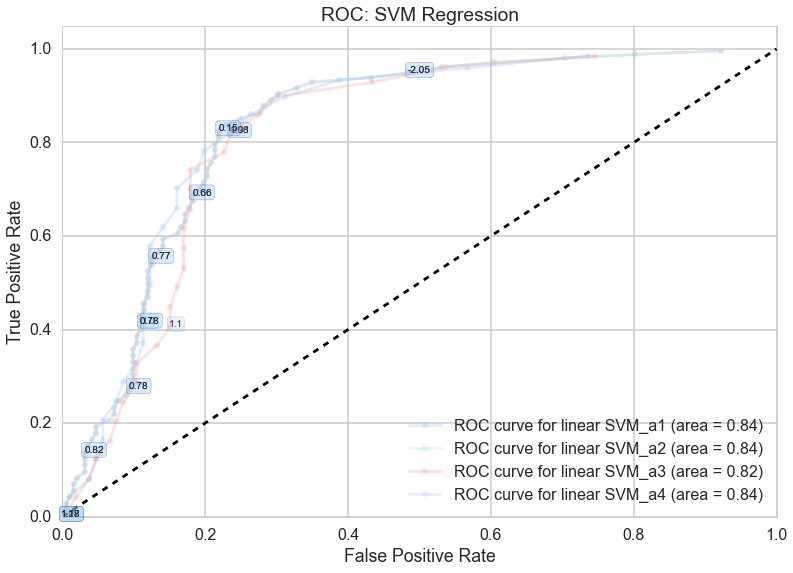

In [33]:
with sns.color_palette("pastel"):
    ax=make_roc("linear SVM_a1", clfsvm_a1, ytest_svm_a1, Xtest_svm_a1, labe=500, proba=False, skip=50)
    make_roc("linear SVM_a2", clfsvm_a2, ytest_svm_a2, Xtest_svm_a2, ax=ax, labe=500, proba=False, skip=50)
    make_roc("linear SVM_a3", clfsvm_a3, ytest_svm_a3, Xtest_svm_a3, ax=ax, labe=500, proba=False, skip=50)
    make_roc("linear SVM_a4", clfsvm_a4, ytest_svm_a4, Xtest_svm_a4, ax=ax, labe=500, proba=False, skip=50)
    ax.set_title('ROC: SVM Regression')

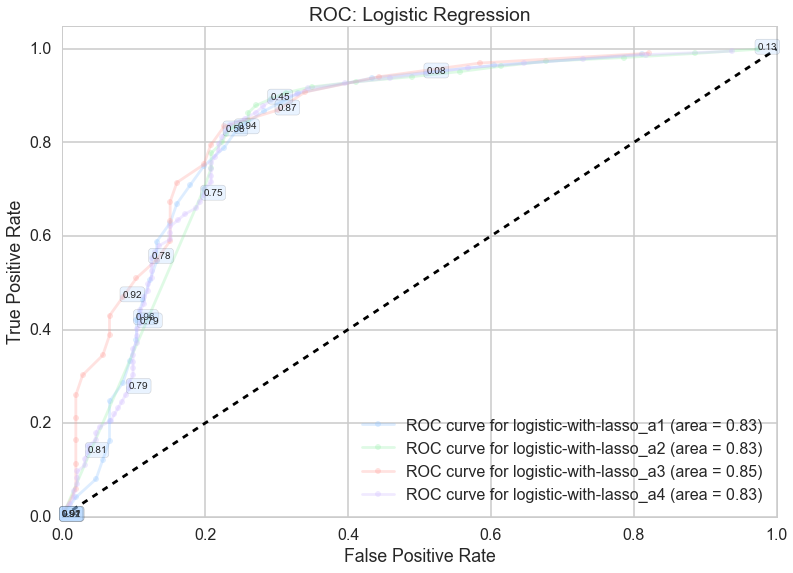

In [34]:
with sns.color_palette("pastel"):
    ax=make_roc("logistic-with-lasso_a1",clflog_a1, ytest_log_a1, Xtest_log_a1, labe=500, skip=50)
    make_roc("logistic-with-lasso_a2",clflog_a2, ytest_log_a2, Xtest_log_a2, ax=ax, labe=500, skip=50)
    make_roc("logistic-with-lasso_a3",clflog_a3, ytest_log_a3, Xtest_log_a3, ax=ax, labe=500, skip=50)
    make_roc("logistic-with-lasso_a4",clflog_a4, ytest_log_a4, Xtest_log_a4, ax=ax, labe=500, skip=50)
    ax.set_title('ROC: Logistic Regression')

Tangent lines to the ROC curve of the classifier give us the highest intercept and hence the lowest associated cost. In a case like ours where we have a high imbalance on the dataset, it is expected to get a much more middling slope, since low slopes usually come with high negative-positive imbalance. Hence we expect to find a good model in the NW corner. We also pick the ROC with the largest Area Under the Curve. 

**While the performance of all our models is similar, based on the AUC and shape of the ROC being close to NW corner, the 'ROC curve for logistic-with-lasso3' (i.e. the one with the standardized, unbalanced train set, and customized cost function') was picked as the most effective.**

## Further Balancing the Data: By Removing Inactive Users

As mentioned earlier there is a set of users who are active in the first week and then have minimal or zero interaction with the course in subsequent weeks. We define inactive users as those users how in the first week exhibit 90% of their total course activity. These represent a third category of users (apart from 'completers' and 'dropouts') who logged in the first week of the course, interacted with the course and realized this course was not for them and dropped out. We want to exclude these users from our modeling prediction since they may be skewing our prediction modeling. In any case these are not as interesting to us since we want our dropouts to be those who interacted with the course for a few weeks and then left due to issues with the course format, rigor, or other reasons. 

We use a standardized and unbalanced dataset from Dataframe A and remove the inactive users. Then we use the best performing model till now, which is the Logistic Regression model with a customized score function to repredict. As can be seen below excluding the inactive users has little or no impacts on the performance of the model.

In [35]:
#Create a dataframe of active users 
df_activeUserID = pd.read_csv('./data/activeUserID.csv')
df_activeUserID = df_activeUserID[['user_id']]
df_activeUserID.shape

(1723, 1)

In [36]:
df_pred_a_withActiveUser = pd.merge(left=df_activeUserID, right=df_pred_a, left_on='user_id', right_on='user_id')

In [37]:
itrain, itest = train_test_split(xrange(df_pred_a_withActiveUser.shape[0]), train_size=0.7)

mask_active_a=np.ones(df_pred_a_withActiveUser.shape[0], dtype='int')
mask_active_a[itrain]=1
mask_active_a[itest]=0
mask_active_a = (mask_active_a==1)

# Standardize
df_pred_std_a_active = to_Standardize(df_pred_a_withActiveUser, STANDARDIZABLE_a, mask_active_a)

In [38]:
# Best Classifier for LOGISTIC REGRESSION (Unbalanced, Standardized, Active users, Custom Score Function)
clflog_a5,_,_,Xtest_log_a5,ytest_log_a5  = do_classify(LogisticRegression(penalty="l1"), {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, df_pred_std_a, lcols_a,'dropout', 1,mask=mask_a, score_func=dropout_gain)

using mask
############# based on standard predict ################
Accuracy on training data: 0.91
Accuracy on test data:     0.92
[[  20   86]
 [  12 1182]]
########################################################


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:12: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


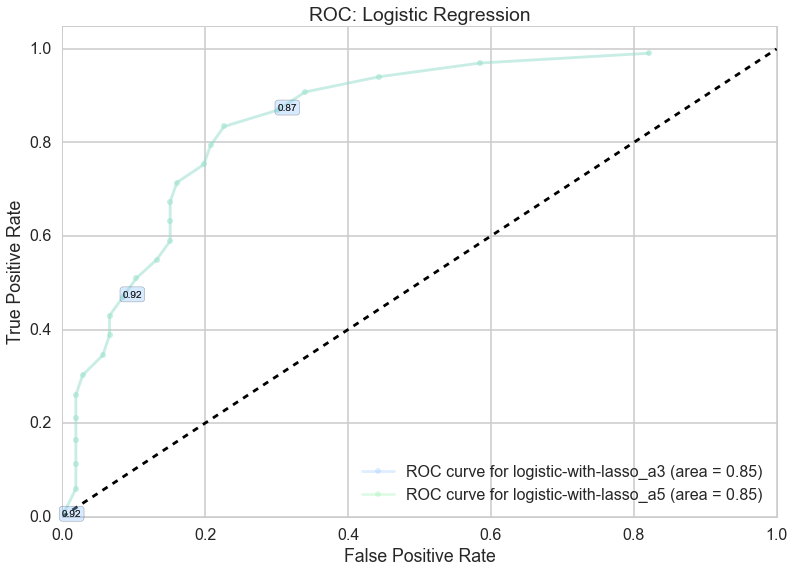

In [39]:
with sns.color_palette("pastel"):
    ax=make_roc("logistic-with-lasso_a3",clflog_a3, ytest_log_a3, Xtest_log_a3, labe=500, skip=50)
    make_roc("logistic-with-lasso_a5",clflog_a5, ytest_log_a5, Xtest_log_a5, ax=ax, labe=500, skip=50)
    ax.set_title('ROC: Logistic Regression')

As stated above and contrary to our expectations, by removing the 'inactive' users had little or no impact on the accuracy of the prediction modeling.

## Additional Insights from Model Results

We explored multiple modelling scenarios by integrating options like standardizing and balancing the data, removing inactive users, incorporating a customized score function, and using two different classification algorithms. This is manifested in the 9 models above. 

The results of improving modeling methodology resulted in minimal improvement in modeling accuracy unlike what we expected. We think this because the dataset is so unbalanced even the changes in modeling design are unable to mask the skew that this unbalanced data presents. We anticipate that using other algorithms that we did not test here such as SVM with RBF kernel and deep learning we may get better prediction.

# <span style="color:blue">Step 5: Model Prediction and ROC Curves for Dataframe B</span>

##Step 5a: Model Prediction for DATAFRAME B

We explore the possibility of looking at the modeling from another angle - i.e., creating a dataframe B which has each day as the feature column and an aggregated activity by day for each user. We want to see if setting up the modeling exercise from a different perspective would improve accuracy. We use **dataframe B** and run through the same 9 models we ran for Dataframe A so that we can compare the performance of the predictors.

### Model Set 1: Linear SVM

###(a) Standardized, Unbalanced Dataset, with both Active and Inactive Users

In [40]:
# Best Classifier for LINEAR SVM (Unbalanced, Standardized, Active+Inactive users)
clfsvm_b1, Xtrain, ytrain, Xtest_svm_b1, ytest_svm_b1 = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df_pred_std_b, lcols_b, 'dropout', 1, mask=mask_b)

using mask
############# based on standard predict ################
Accuracy on training data: 0.92
Accuracy on test data:     0.91
[[  19   98]
 [  16 1167]]
########################################################


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:12: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


###(b) Standardized, Balanced Dataset, with both Active and Inactive Users

In [41]:
# Find Best Classifier for LINEAR SVM (Balanced, Standardized)
clfsvm_b2, Xtrain, ytrain, Xtest_svm_b2, ytest_svm_b2 = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df_pred_std_bal_b, lcols_b, 'dropout', 1, mask=mask_bal_b)

using mask
############# based on standard predict ################
Accuracy on training data: 0.80
Accuracy on test data:     0.85
[[ 126   63]
 [ 510 3091]]
########################################################


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:12: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


###(c) Standardized, Unbalanced Dataset, with both Active and Inactive Users, AND with Customized Score Function

In [42]:
# Best Classifier for LINEAR SVM (Unbalanced, Standardized, Active+Inactive users, Custom Score Function)
clfsvm_b3, Xtrain, ytrain, Xtest_svm_b3, ytest_svm_b3 = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df_pred_std_b, lcols_b, 'dropout', 1, mask=mask_b, score_func=dropout_gain)

using mask
############# based on standard predict ################
Accuracy on training data: 0.91
Accuracy on test data:     0.91
[[   5  112]
 [   2 1181]]
########################################################


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:12: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


###(d) Standardized, Balanced Dataset, with both Active and Inactive Users, AND with Customized Score Function

In [43]:
# Find Best Classifier for LINEAR SVM (Balanced, Standardized)
clfsvm_b4, Xtrain, ytrain, Xtest_svm_b4, ytest_svm_b4 = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df_pred_std_bal_b, lcols_b, 'dropout', 1, mask=mask_bal_b, score_func=dropout_gain)

using mask
############# based on standard predict ################
Accuracy on training data: 0.80
Accuracy on test data:     0.85
[[ 126   63]
 [ 510 3091]]
########################################################


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:12: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.



### Model Set 2: Logistic Regression

###(a) Standardized, Unbalanced Dataset, with both Active and Inactive Users

In [44]:
# Best Classifier for LOGISTIC REGRESSION (Unbalanced, Standardized, Active+Inactive users)
clflog_b1,_,_, Xtest_log_b1, ytest_log_b1 = do_classify(LogisticRegression(penalty="l1"), {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, df_pred_std_b, lcols_b,'dropout', 1,mask=mask_b)

using mask
############# based on standard predict ################
Accuracy on training data: 0.92
Accuracy on test data:     0.91
[[  22   95]
 [  20 1163]]
########################################################


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:12: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


###(b) Standardized, Balanced Dataset, with both Active and Inactive Users

In [45]:
#  Best Classifier for LOGISTIC REGRESSION (Balanced, Standardized)
clflog_b2,_,_,Xtest_log_b2, ytest_log_b2 = do_classify(LogisticRegression(penalty="l1"), {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, df_pred_std_bal_b, lcols_b,'dropout', 1,mask=mask_bal_b)

using mask
############# based on standard predict ################
Accuracy on training data: 0.80
Accuracy on test data:     0.85
[[ 124   65]
 [ 513 3088]]
########################################################


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:12: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


###(c) Standardized, Unbalanced Dataset, with both Active and Inactive Users, AND with Customized Score Function

In [46]:
# Best Classifier for LOGISTIC REGRESSION (Unbalanced, Standardized, Active+Inactive users, Custom Score Function)
clflog_b3,_,_,Xtest_log_b3, ytest_log_b3 = do_classify(LogisticRegression(penalty="l1"), {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, df_pred_std_b, lcols_b,'dropout', 1,mask=mask_b, score_func=dropout_gain)

using mask
############# based on standard predict ################
Accuracy on training data: 0.91
Accuracy on test data:     0.91
[[   4  113]
 [   3 1180]]
########################################################


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:12: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


### (d) Standardized, Balanced Dataset, with both Active and Inactive Users, AND with Customized Score Function

In [47]:
# Find Best Classifier for LINEAR SVM (Balanced, Standardized)
clflog_b4,_,_,Xtest_log_b4, ytest_log_b4 = do_classify(LogisticRegression(penalty="l1"), {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, df_pred_std_bal_b, lcols_b,'dropout', 1,mask=mask_bal_b, score_func=dropout_gain)

using mask
############# based on standard predict ################
Accuracy on training data: 0.80
Accuracy on test data:     0.85
[[ 124   65]
 [ 513 3088]]
########################################################


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:12: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


To compare the results of the models we present using Dataframe B we plot ROC curves as shown below.

##Step 5b: ROC Curves for Dataframe B

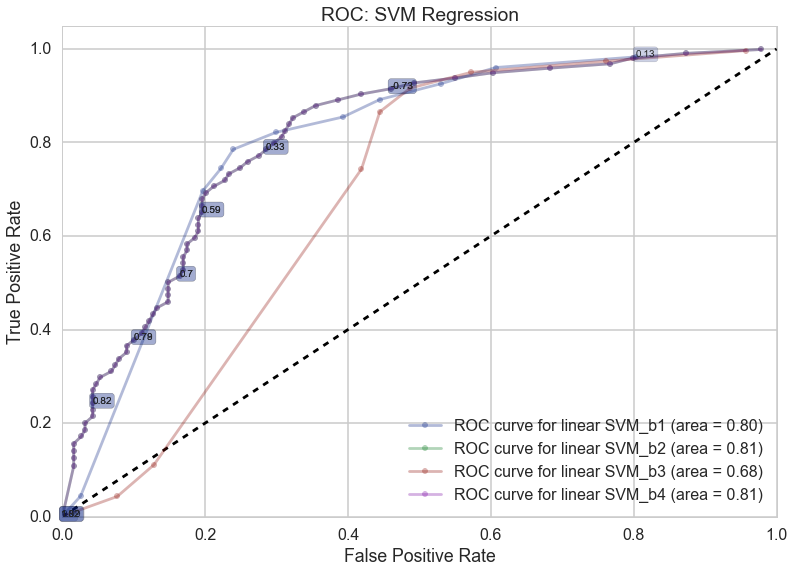

In [48]:
with sns.color_palette("dark"):
    ax=make_roc("linear SVM_b1", clfsvm_b1, ytest_svm_b1, Xtest_svm_b1, labe=500, proba=False, skip=50)
    make_roc("linear SVM_b2", clfsvm_b2, ytest_svm_b2, Xtest_svm_b2, ax=ax, labe=500, proba=False, skip=50)
    make_roc("linear SVM_b3", clfsvm_b3, ytest_svm_b3, Xtest_svm_b3, ax=ax, labe=500, proba=False, skip=50)
    make_roc("linear SVM_b4", clfsvm_b4, ytest_svm_b4, Xtest_svm_b4, ax=ax, labe=500, proba=False, skip=50)
    ax.set_title('ROC: SVM Regression')

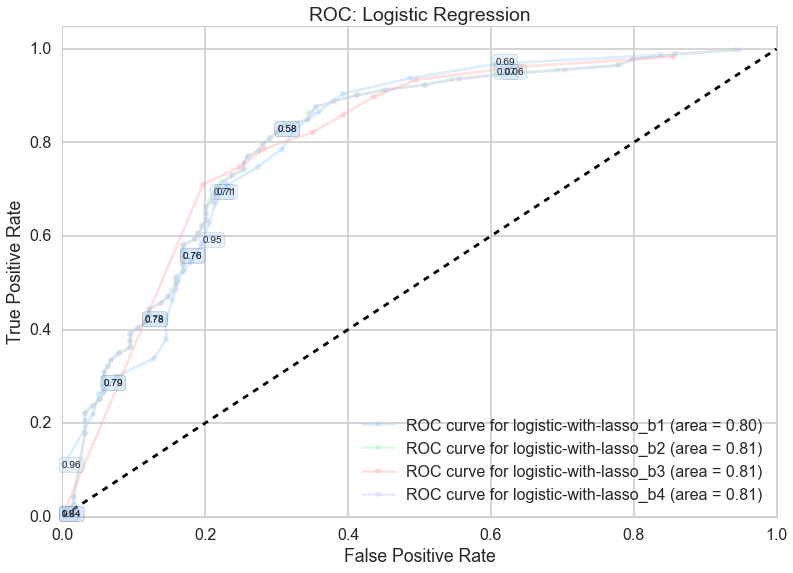

In [49]:
with sns.color_palette("pastel"):
    ax=make_roc("logistic-with-lasso_b1",clflog_b1, ytest_log_b1, Xtest_log_b1, labe=500, skip=50)
    make_roc("logistic-with-lasso_b2",clflog_b2, ytest_log_b2, Xtest_log_b2, ax=ax, labe=500, skip=50)
    make_roc("logistic-with-lasso_b3",clflog_b3, ytest_log_b3, Xtest_log_b3, ax=ax, labe=500, skip=50)
    make_roc("logistic-with-lasso_b4",clflog_b4, ytest_log_b4, Xtest_log_b4, ax=ax, labe=500, skip=50)
    ax.set_title('ROC: Logistic Regression')

As we can see, a modeling strategy with Dataframe B did not lead to an improvement in accuracy. 

##Further Balancing the Data: By Removing Inactive Users

For Dataframe B (similar to A), we remove the inactive users to see how the modeling performance changes for the best performing predictor till now which was Logistic Regression with a custom score function.

In [50]:
#Create dataframe with ACTIVE USERS only
df_pred_b_withActiveUser = pd.merge(left=df_activeUserID, right=df_pred_b, left_on='user_id', right_index=True)

#Create train and test sets
itrain, itest = train_test_split(xrange(df_pred_b_withActiveUser.shape[0]), train_size=0.7)
mask_active_b=np.ones(df_pred_b_withActiveUser.shape[0], dtype='int')
mask_active_b[itrain]=1
mask_active_b[itest]=0
mask_active_b = (mask_active_b==1)

# Standardize
df_pred_std_b_active = to_Standardize(df_pred_b_withActiveUser, STANDARDIZABLE_b, mask_active_b)

# Best Classifier for LOGISTIC REGRESSION (Unbalanced, Standardized, Active users, Custom Score Function)
clflog_b5,_,_,Xtest_log_b5,ytest_log_b5  = do_classify(LogisticRegression(penalty="l1"), {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, df_pred_std_b, lcols_b,'dropout', 1,mask=mask_b, score_func=dropout_gain)


using mask
############# based on standard predict ################
Accuracy on training data: 0.91
Accuracy on test data:     0.91
[[   4  113]
 [   3 1180]]
########################################################


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:12: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [51]:
#df_pred_b.head()

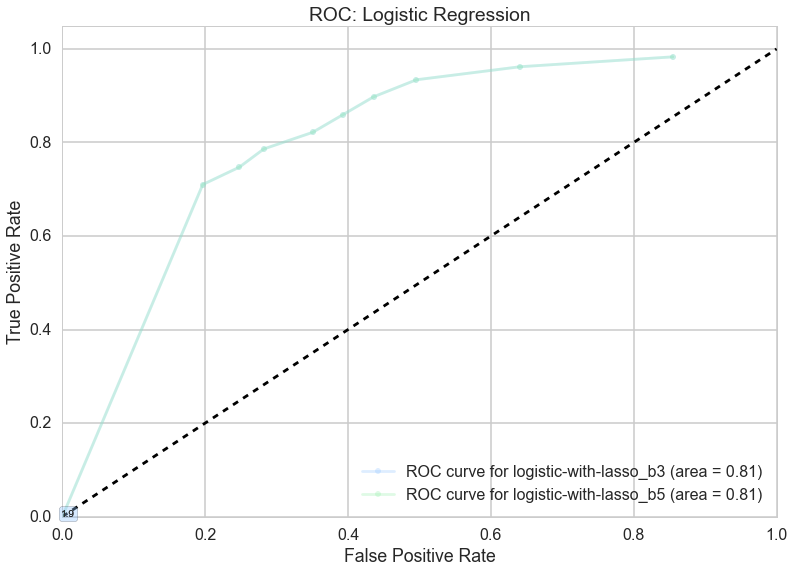

In [52]:
with sns.color_palette("pastel"):
    ax=make_roc("logistic-with-lasso_b3",clflog_b3, ytest_log_b3, Xtest_log_b3, labe=500, skip=50)
    make_roc("logistic-with-lasso_b5",clflog_b5, ytest_log_b5, Xtest_log_b5, ax=ax, labe=500, skip=50)
    ax.set_title('ROC: Logistic Regression')

###Methodolgy Choice:

Based on the ROC plots with Dataframe A (features by activity) and Dataframe B (features by day), we see that predictions are similar with the former methodology (Dataframe A) giving a slightly better prediction. We pick the logistic-regression with a custom score function on a standardized, unbalanced dataset with active and inactive users.

In [53]:
print 'Best choosen Classifier has the following characteristics: '
print 'Classifier parameters: ', clflog_a3
print ''
print 'Classifier coefficients: ',clflog_a3.coef_

Best choosen Classifier has the following characteristics: 
Classifier parameters:  LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

Classifier coefficients:  [[-0.01614231  0.          0.          0.          0.          0.          0.
   0.         -0.18792078 -0.53092995]]


#<span style="color:blue">Step 6: Feature Selection Using Lasso</span>

We have a recommendation tool which after a few weeks in to the course will flag to the MOOC organizers those users who are likely to dropout. 

The next thing we want to do is identify some features which are the best indicators of identifying a completor versus a dropout and which can subsequently be improved upon to ensure high retentiion rate. 

We implement feature selection using Lasso to identify features which contribute the most to identifying someone who completes the course. This would help the MOOC organizers to be able to improve on specific features of the course. 

We found that low quiz/problem-related activity and less time spent on the course in the initial weeks to be the most important features to predict an eventual dropout.

In [54]:
#LASSO
eps = 5e-6  # the smaller it is the longer is the path

In [55]:
# Using standardized dataframe A
X = df_pred_std_a.drop(['user_id', 'username', 'dropout'], 1)
y = pd.DataFrame(df_pred_std_a.dropout).values.astype(np.double)

In [56]:
%time
print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps, fit_intercept=False)

print("Computing regularization path using the elastic net...")
alphas_enet, coefs_enet, _ = enet_path(X, y, eps=eps, l1_ratio=0.8, fit_intercept=False)

Wall time: 0 ns
Computing regularization path using the lasso...
Computing regularization path using the elastic net...


In [57]:
#print alphas_lasso.shape
#print coefs_lasso.shape
#print coefs_lasso.T.shape
b = np.reshape(np.ravel(coefs_lasso.T), (100,10))
print b.shape

#print alphas_enet.shape
#print coefs_enet.shape
#print coefs_enet.T.shape
c = np.reshape(np.ravel(coefs_enet.T), (100,10))
print c.shape

(100L, 10L)
(100L, 10L)


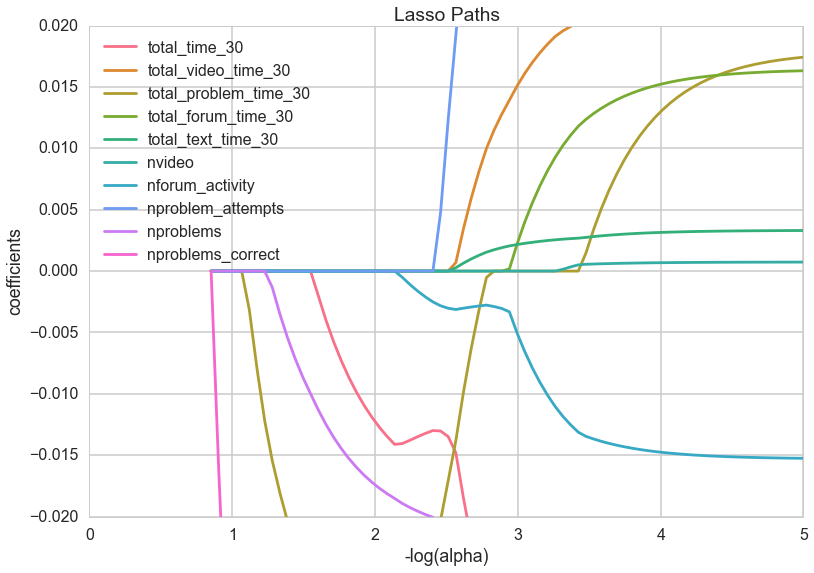

In [58]:
col = sns.color_palette("husl", 10)

# make the lasso path
plt.figure(1)
ax = plt.gca()
ax.set_color_cycle(col)
#l1 = plt.plot(-np.log10(alphas_lasso), coefs_lasso.T)
l1 = plt.plot(-np.log10(alphas_lasso), b)
#l2 = plt.plot(-np.log10(alphas_enet), coefs_enet.T, linestyle='--')
#l2 = plt.plot(-np.log10(alphas_enet), c, linestyle='--')
plt.xlim([0, 5])
plt.ylim([-0.02, 0.02])
plt.xlabel('-log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso Paths')
#plt.title('Lasso and Elastic-Net Paths')
#plt.legend((l1[-1], l2[-1]), ('Lasso', 'Elastic-Net'), loc='lower left')
plt.legend(l1, list(X.columns.values), loc='upper left')

Based on the lasso paths, we can see that the features related to'problems' (specifically the 'number of problems that were correct', 'time spent on problems', 'the number of problems tried', and 'number of attempts per problem') were the most important. This was followed by 'total time spent on course' and 'videos' which were the next most important features. This also indicates that forum activity and reading 'texts' was not as important feature as the others. This can serve as a helpful indicator to MOOC organizers to develop these areas.

#Conclusion: 
* We implemented discriminate classifiers using logistic regression and support vector machine - first using the different activity type and secondly using the daily activity in the first three weeks as features.
* We found that low quiz/problem-related activity and less time spent on the course in the initial weeks to be the most important features to predict an eventual dropout.
* Our classifiers were fairly accurate, and performance improved when using Logistic Regression along with a customized function to measure accuracy.
* Our end product is a recommendation tool which after a few weeks in to the course will flag to the MOOC organizers those users who are likely to dropout. 
* At this point the MOOC organizers can supplement the at-risk students with additional resources.

#Next Steps:
* We would use other machine learning algorithms such as SVM with penalizers, or RBF kernel to get a better prediction.
* We would also do sentiment analysis and incorporate user sentiment data as part of our prediction modeling though based on literature research it has a lower contribution to prediction effectiveness since only a small fraction of the entire class engages in forums.  
* We could also explore refining our definition of a dropout based on accounting for user goals as defined in the beginning of the class. Another metric for dropout could be their passing grade. 
* We would also like to refine our scoring function.
* Currently our prediction modeling could identify students who were most likely to drop out based on their behavior within the first two weeks. In order to assist the MOOC organizer we could further identify the defining reasons they were dropping out so that they can be targeted appropriately with additional materials.

#Reference: 

1. CS109 content: lecture slides, lab, and homeworks. Available online at: http://cs109.github.io/2015/

2. Amnueypornsakul, B., Bhat, S. and Chinprutthiwong, P. (2014a). Predicting Attrition Along the Way: The UIUC Model. The 2014 Conference on Empirical Methods In Natural Language Processing. (55-59). Available online at: http://www.aclweb.org/anthology/W14-4110
